# Full Sim Training

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm_notebook as tqdm
from tqdm import trange, tnrange

from deep_qnet_agent import DQNAgentDemo
from environment import Environment, LanderEnvironment
from full_lander_sim import *
from gym import wrappers

In [4]:
def save_agent(agent, env, fname):
    env.reset()
    
    agentcon = agent_config()
    netcon = network_config()
    for key in agentcon.keys():
        agentcon[key] = getattr(agent, key)
    for key in netcon.keys():
        netcon[key] = getattr(agent, key)
        
    netparams = {}
    netparams['w_in'] = agent.sess.run(agent.w_in)
    netparams['b_in'] = agent.sess.run(agent.b_in)
    netparams['W'] = agent.sess.run(agent.W)
    agent_data = {'agentcon':agentcon, 'netcon':netcon, 'netparams':netparams,
                 'SA':(agent.state_size, agent.action_size), 'env':env}
    pickle.dump(agent_data,open(fname,'wb'))
    
def save_deep_agent(agent, env, fname):
    env.reset()
    
    agentcon = agent_config()
    netcon = network_config()
    for key in agentcon.keys():
        agentcon[key] = getattr(agent, key)
    for key in netcon.keys():
        netcon[key] = getattr(agent, key)
        
    netparams = {}
    for w in agent.weights.keys():
        netparams[w] = agent.sess.run(agent.weights[w])
    for b in agent.biases.keys():
        netparams[b] = agent.sess.run(agent.biases[b])

    agent_data = {'agentcon':agentcon, 'netcon':netcon, 'netparams':netparams,
                 'SA':(agent.state_size, agent.action_size), 'env':env}
    pickle.dump(agent_data,open(fname,'wb'))
    
def load_agent(fname):
    agent_data = pickle.load(open(fname,'rb'))
    env = agent_data['env']
    agent = QNetAgent(agent_data['agentcon'],agent_data['netcon'],env)

    netparams = agent_data['netparams']
    with agent.sess.as_default():
        agent.w_in.load(netparams['w_in'])
        agent.b_in.load(netparams['b_in'])
        agent.W.load(netparams['W'])
    print(agent.sess.run(agent.W))
    
    return agent, env

def load_deep_agent(fname):
    agent_data = pickle.load(open(fname,'rb'))
    env = agent_data['env']
    agent = DQNAgentDemo(agent_data['agentcon'],agent_data['netcon'],env,[])

    netparams = agent_data['netparams']
    with agent.sess.as_default():
        for w in agent.weights.keys():
            agent.weights[w].load(netparams[w])
        for b in agent.biases.keys():
            agent.biases[b].load(netparams[b])
    return agent, env

def reset_agent(agent, netcon, agentcon):
    """
    This function resets an agent's hyperparameters while maintaining its weights
    """
    # Reset hyperparams
    for key in agentcon.keys():
        setattr(agent, key, agentcon[key])
    for key in netcon.keys():
        setattr(agent, key, netcon[key])
    agent.eps = agent.eps0
    
    # Assign target network
    agent.sess.run(agent.wt_assign)
    agent.sess.run(agent.bt_assign)
    agent.sess.run(agent.Wt_assign)
    
    # Memory (maintains state transition memory)
    agent.prev_s=[]
    agent.prev_a=[]
    agent.step_count=0
    agent.ep_no=0
    
    return agent

def do_run(agent, env, N_ep):
    R_ep = []
    t = tnrange(N_ep, desc='bar_desc', leave=True)
#     for ep_no in tqdm(range(N_ep)):
    for ep_no in t:
        observation = env.reset()
        done = False
        r = 0
        n_step = 0
        while not done:
            action = agent.action_select(env,observation)
            observation, reward, done, info = env.step(action)
            agent.update_net(observation,reward,done)
            r += reward
            n_step +=1
        R_ep.append(r)
        t.set_description('Last reward: {}'.format(r))
        t.refresh()
    return R_ep, agent, env

def agent_demo(agent, env, N_ep):
    R_ep = []
    for ep_no in tqdm(range(N_ep)):
        observation = env.reset()
        done = False
        r = 0
        while not done:
            action = agent.action_select(env,observation)
            observation, reward, done, _ = env.step(action)
            env.render()
            r += reward
        R_ep.append(r)
    return R_ep

def data_smooth(data,n_avg):
	# A function to average data over n_avg timesteps
	ind_vec = np.arange(n_avg,len(data)+1,n_avg)
	data_avg = [0]
	for ind in ind_vec:
		data_avg.append(np.mean(data[ind-n_avg:ind]))
	return data_avg

## Environment

In [ ]:
demo_heuristic_lander(MarsLander())

In [6]:
exp_heuristic = exp_heuristic_lander(MarsLander())
fname = 'lander_full_heuristic_13_11'
np.save(open(fname,'wb'),exp_heuristic)

Episode 1
observations: +0.00 -0.00 +0.00 +0.00 -0.00 +0.00 +1.00 +1.00
step 1872 total_reward -48.42
Episode 1
observations: +0.00 -0.00 +0.00 +0.00 -0.00 +0.00 +1.00 +1.00
step 1876 total_reward -41.31
Episode 1
observations: -0.00 -0.00 +0.00 +0.00 +0.00 +0.00 +1.00 +1.00
step 1872 total_reward -46.27
Episode 1
observations: -0.00 -0.00 +0.00 +0.00 +0.00 +0.00 +1.00 +1.00
step 1879 total_reward -45.66
Episode 1
observations: +0.01 -0.00 +0.00 +0.00 -0.00 +0.00 +1.00 +1.00
step 1873 total_reward -48.65


In [7]:
np.shape(exp_heuristic)

(9377, 5)

## Training

In [5]:
def network_config():
    netcon = {}
    netcon['alpha'] = 0.001
    netcon['clip_norm'] = 1.0
    netcon['update_steps'] = 50
    netcon['N_hid_1'] = 120
    netcon['N_hid_2'] = 80
    netcon['activation'] = 'tanh'
    netcon['init_mag'] = 0.01
    return netcon

def agent_config():
    agentcon = {}
    agentcon['gamma'] = 0.9
    agentcon['eps0'] = 0.5
    agentcon['epsf'] = 0.0
    agentcon['n_eps'] = 800
    agentcon['minib'] = 20
    agentcon['minib_demo'] = 50
    agentcon['max_mem'] = 500000
    return agentcon

In [ ]:
fname = 'lander_full_heuristic_13_11'
demo_exp = np.load(open(fname,'rb'),allow_pickle=True).tolist()

print(agent_config())
print(network_config())

mean_end = -500
agent_no = 0
while mean_end<100:
    agent_no+=1
    print('Agent ' + str(agent_no))
    
    N_ep = 600
    env = LanderEnvironment()W
    agent = QNetAgentDemo(agent_config(),network_config(),env,demo_exp)
    
    R_ep, agent, env = do_run(agent, env, N_ep)
    mean_end = np.mean(R_ep[-100:])
    print('R end: ' + repr(mean_end))
    
    save_agent(agent, env, 'agent'+str(agent_no))
    pickle.dump(R_ep, open('reward'+str(agent_no),'wb'))

## Deep Agents

In [6]:
fname = 'lander_full_heuristic_13_11'
demo_exp = np.load(open(fname,'rb'),allow_pickle=True).tolist()

env = LanderEnvironment()
agent = DQNAgentDemo(agent_config(),network_config(),env,demo_exp)

/home/callum/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
def t_qnet(agent,env,n_step):
    pr = cProfile.Profile()
    s = env.reset()
    pr.enable()
    for _ in range(n_step):
        a = agent.action_select(env,s)
        s, r, done, _ = env.step(a)
        agent.update_net(s,r,done)
    pr.disable()
    sortby = 'cumulative'
    ps = pstats.Stats(pr).sort_stats(sortby)
    return ps

In [12]:
import cProfile, pstats
env = LanderEnvironment()
agent = DQNAgentDemo(agent_config(),network_config(),env,demo_exp)
ps = t_qnet(agent,env,41)
ps.print_stats()

         91767 function calls (90208 primitive calls) in 0.306 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       41    0.034    0.001    0.270    0.007 /home/callum/smart-ml/RL-agents/deep_qnet_agent.py:234(update_net)
      138    0.000    0.000    0.209    0.002 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:840(run)
      138    0.003    0.000    0.209    0.002 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1084(_run)
      138    0.001    0.000    0.178    0.001 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1310(_do_run)
      138    0.000    0.000    0.177    0.001 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1354(_do_call)
      138    0.000    0.000    0.177    0.001 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1337(_run_fn

Run the deep agent

In [24]:
fname = 'lander_full_heuristic_13_11'
demo_exp = np.load(open(fname,'rb'),allow_pickle=True).tolist()

print(agent_config())
print(network_config())

N_attempt = 20
for agent_no in range(N_attempt):
    print('Agent ' + str(agent_no))
    
    N_ep = 1000
    env = LanderEnvironment()
    agent = DQNAgentDemo(agent_config(),network_config(),env,demo_exp)
    
    R_ep, agent, env = do_run(agent, env, N_ep)
    mean_end = np.mean(R_ep[-100:])
    print('R end: ' + repr(mean_end))
    
    save_deep_agent(agent, env, 'agent'+str(agent_no))
    pickle.dump(R_ep, open('reward'+str(agent_no),'wb'))

{'gamma': 0.9, 'eps0': 0.5, 'epsf': 0.0, 'n_eps': 800, 'minib': 20, 'minib_demo': 50, 'max_mem': 500000}
{'alpha': 0.001, 'clip_norm': 1.0, 'update_steps': 50, 'N_hid_1': 120, 'N_hid_2': 80, 'activation': 'tanh', 'init_mag': 0.01}
Agent 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


KeyboardInterrupt: 

In [9]:
R = agent_demo(agent,env,5)

In [10]:
env.gym_env.close()

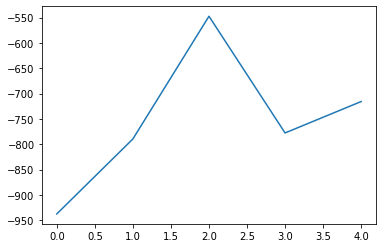

In [11]:
plt.plot(R)

In [21]:
agent.clip_norm

1